<a href="https://colab.research.google.com/github/chahatpatel2003/CSCI-167/blob/main/notebook_9_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-1radwbvp
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-1radwbvp
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=41d5742785101182d7fddd3949129cf4e125fb3219591db4bf3016ecd7d64c24
  Stored in directory: /tmp/pip-ephem-wheel-cache-aakh3oqp/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40
Epoch     0, train error 55.00, test error 63.50
Epoch     1, train error 41.85, test error 53.00

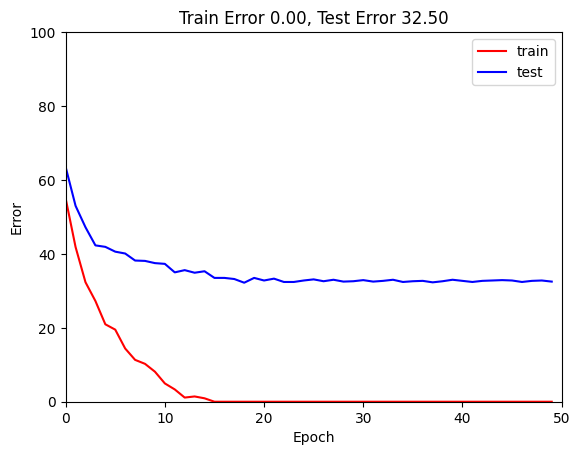

Epoch     0, train error 53.97, test error 56.00
Epoch     1, train error 44.47, test error 48.90
Epoch     2, train error 37.31, test error 42.90
Epoch     3, train error 32.54, test error 43.60
Epoch     4, train error 28.70, test error 39.00
Epoch     5, train error 25.53, test error 40.40
Epoch     6, train error 20.79, test error 39.00
Epoch     7, train error 17.55, test error 37.10
Epoch     8, train error 13.84, test error 37.00
Epoch     9, train error 13.74, test error 38.80
Epoch    10, train error 10.45, test error 36.90
Epoch    11, train error 9.96, test error 37.90
Epoch    12, train error 7.18, test error 35.60
Epoch    13, train error 5.66, test error 34.80
Epoch    14, train error 5.22, test error 35.60
Epoch    15, train error 4.56, test error 36.30
Epoch    16, train error 2.68, test error 35.80
Epoch    17, train error 2.50, test error 35.20
Epoch    18, train error 0.64, test error 33.40
Epoch    19, train error 0.38, test error 34.30
Epoch    20, train error 0.00

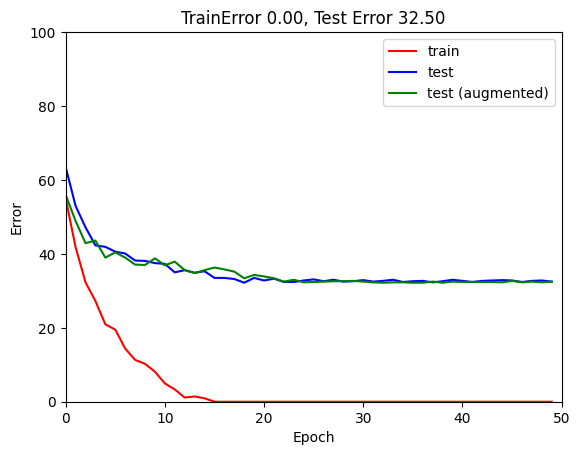

In [1]:
!pip install git+https://github.com/greydanus/mnist1d

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

D_i = 40
D_k = 200
D_o = 10

model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o)
)

def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test = torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

model.apply(weights_init)

n_epoch = 50
errors_train = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
    for i, batch in enumerate(data_loader):
        x_batch, y_batch = batch
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test[epoch] = 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    print(f'Epoch {epoch:5d}, train error {errors_train[epoch]:3.2f}, test error {errors_test[epoch]:3.2f}')

fig, ax = plt.subplots()
ax.plot(errors_train, 'r-', label='train')
ax.plot(errors_test, 'b-', label='test')
ax.set_ylim(0, 100)
ax.set_xlim(0, n_epoch)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
ax.set_title('Train Error %3.2f, Test Error %3.2f' % (errors_train[-1], errors_test[-1]))
ax.legend()
plt.show()

def augment(input_vector):
    data_out = np.array(input_vector, copy=True)
    shift = np.random.randint(0, input_vector.shape[0])
    if shift != 0:
        data_out = np.roll(data_out, shift)
    scale = np.random.uniform(0.8, 1.2)
    data_out = data_out * scale
    return data_out

n_data_orig = data['x'].shape[0]
n_data_augment = n_data_orig + 4000
augmented_x = np.zeros((n_data_augment, D_i))
augmented_y = np.zeros(n_data_augment)

augmented_x[0:n_data_orig, :] = data['x']
augmented_y[0:n_data_orig] = data['y']

for c_augment in range(n_data_orig, n_data_augment):
    random_data_index = random.randint(0, n_data_orig - 1)
    augmented_x[c_augment, :] = augment(data['x'][random_data_index, :])
    augmented_y[c_augment] = data['y'][random_data_index]

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

x_train = torch.tensor(augmented_x.astype('float32'))
y_train = torch.tensor(augmented_y.transpose().astype('long'))
x_test = torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

model.apply(weights_init)

n_epoch = 50
errors_train_aug = np.zeros((n_epoch))
errors_test_aug = np.zeros((n_epoch))

for epoch in range(n_epoch):
    for i, batch in enumerate(data_loader):
        x_batch, y_batch = batch
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train_aug[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test_aug[epoch] = 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    print(f'Epoch {epoch:5d}, train error {errors_train_aug[epoch]:3.2f}, test error {errors_test_aug[epoch]:3.2f}')

fig, ax = plt.subplots()
ax.plot(errors_train, 'r-', label='train')
ax.plot(errors_test, 'b-', label='test')
ax.plot(errors_test_aug, 'g-', label='test (augmented)')
ax.set_ylim(0, 100)
ax.set_xlim(0, n_epoch)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f' % (errors_train_aug[-1], errors_test_aug[-1]))
ax.legend()
plt.show()
